# Prep True EoR files for end-to-end run

Nick Kern

Sept, 2020

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import glob
import hera_pspec as hp
import hera_cal as hc
from pyuvdata import UVBeam, UVData, UVCal, UVFlag, utils as uvutils
from memory_profiler import memory_usage
import copy
import matplotlib.gridspec as gridspec
from scipy import interpolate
import uvtools as uvt
import os

In [2]:
# get LSTbinned data files
dfiles = sorted(glob.glob("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/"
                          "zen.grp1.of1.LST.*.HH.OCRSL.uvh5"))

In [3]:
# LSTbinned metadata
uvd = UVData()
uvd.read(dfiles[0], read_data=False)

uvd_antp, uvd_ants = uvd.get_ENU_antpos()
uvd_antpd = dict(zip(uvd_ants, uvd_antp))
uvd_bls = uvd.get_antpairs()
uvd_blvecs = np.array([uvd_antpd[bl[1]] - uvd_antpd[bl[0]] for bl in uvd_bls])[:, :]

antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.28190.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


In [4]:
# get eor data files
efiles = sorted(glob.glob("/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/"
                          "zen.*.eor.true.uvh5"))

In [5]:
efiles

['/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.26719.eor.true.uvh5',
 '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.27465.eor.true.uvh5',
 '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.28211.eor.true.uvh5',
 '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.28956.eor.true.uvh5',
 '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.29702.eor.true.uvh5',
 '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.30448.eor.true.uvh5',
 '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.31193.eor.true.uvh5',
 '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.31939.eor.true.uvh5',
 '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.32685.eor.true.uvh5',
 '/lustre/

In [6]:
# read eor data
eor = UVData()
eor.read(efiles[0], read_data=False)

eor_antp, eor_ants = eor.get_ENU_antpos()
eor_antpd = dict(zip(eor_ants, eor_antp))
eor_bls = eor.get_antpairs()
eor_blvecs = np.array([eor_antpd[bl[1]] - eor_antpd[bl[0]] for bl in eor_bls])[:, :]
eor_blvec_dict = dict(zip(eor_bls, eor_blvecs))

Telescope RIMEz calculation is not in known_telescopes.


In [7]:
# get uvd2eor dictionary
uvd2eor = {}
for i, bl in enumerate(uvd_bls):
    distance = np.min([np.linalg.norm(eor_blvecs - uvd_blvecs[i], axis=1),
                       np.linalg.norm(eor_blvecs + uvd_blvecs[i], axis=1)], axis=0)
    if distance.min() < 1:
        match = np.argmin(distance)
        uvd2eor[bl] = eor_bls[match]

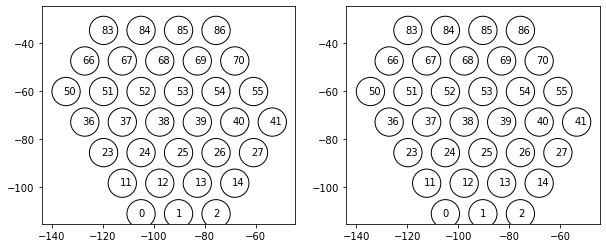

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
for i, a in enumerate(eor_ants):
    ax.scatter(eor_antp[i,0], eor_antp[i,1], s=800, fc='None', ec='k')
    ax.text(eor_antp[i,0]-1, eor_antp[i,1]-1, a)
    
ax = axes[1]
for i, a in enumerate(uvd_ants):
    ax.scatter(uvd_antp[i,0], uvd_antp[i,1], s=800, fc='None', ec='k')
    ax.text(uvd_antp[i,0]-1, uvd_antp[i,1]-1, a)

In [ ]:
# read eor file
eor.read(efiles, polarizations=[-5, -6])

In [9]:
eor_lsts = np.unique(eor.lst_array)

In [15]:
# iterate over LST binned files
for df in dfiles:
    # load dfile
    basename = os.path.basename(df)
    uvd = UVData()
    uvd.read(df, read_data=True)
    
    # get nearest LST neighbor from EoR
    uvd_lsts = np.unique(uvd.lst_array)
    eor_tinds = [np.argmin(np.abs(eor_lsts - l)) for l in uvd_lsts]
    
    # populate uvd
    for bl in uvd.get_antpairs():
        bltinds = uvd.antpair2ind(bl)
        uvd.data_array[bltinds, 0, :, :] = eor.get_data(bl)[eor_tinds]
        
    # write
    fname = "data/{}".format(basename.replace("grp1.of1", "eor").replace(".OCRSL", ""))
    print("writing {}".format(fname))
    uvd.write_uvh5(fname, clobber=True)

antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.28190.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.28190.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.37586.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.37586.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.46983.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.56380.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.56380.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.65776.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.65776.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.75173.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.75173.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.84569.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.84569.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.93966.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.93966.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.1.03362.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.1.03362.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.1.12759.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.1.12759.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.22156.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.31552.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.40949.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.50345.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.59742.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.69139.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.78535.HH.uvh5
